In [666]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("price_data.csv")

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               249 non-null    object
 1   avg_monthly_price  249 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.0+ KB


In [668]:
df['date']=pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               249 non-null    datetime64[ns]
 1   avg_monthly_price  249 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.0 KB


In [670]:
df.set_index('date', inplace=True)
df.sort_index(inplace=True)


In [672]:
type(df.index)


pandas.core.indexes.datetimes.DatetimeIndex

In [674]:
df.loc['2021-01':'2022-12']

,avg_monthly_price
date,
2021-01-01,10425
2021-02-01,10838
2021-03-01,12075
2021-04-01,10863
2021-05-01,10863
2021-06-01,5070
2021-07-01,4638
2021-08-01,4569
2021-09-01,4715


In [676]:
df.isnull().sum()


avg_monthly_price    0
dtype: int64

In [678]:
df['avg_monthly_price'] = df['avg_monthly_price'].interpolate(method='linear')


In [680]:
df = df.resample('ME').mean()

In [682]:
from scipy.stats import zscore

df['z_score'] = zscore(df['avg_monthly_price'])
#df['anomaly'] = df['z_score'].abs() > 2


In [684]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(
    df['avg_monthly_price'],
    model='additive',
    period=12
)

residual = decomposition.resid

threshold = 2 * residual.std()
df['anomaly'] = abs(residual) > threshold  



In [686]:
df[df['anomaly'] == True]

,avg_monthly_price,z_score,anomaly
date,,,
2013-11-30,11016.0,1.106365,True
2021-03-31,12075.0,1.484667,True
2021-04-30,10863.0,1.051710,True
2021-05-31,10863.0,1.051710,True
2021-06-30,5070.0,-1.017696,True
2021-07-31,4638.0,-1.172017,True
2021-08-31,4569.0,-1.196666,True
2023-09-30,7040.0,-0.313962,True
2023-10-31,7262.0,-0.234658,True


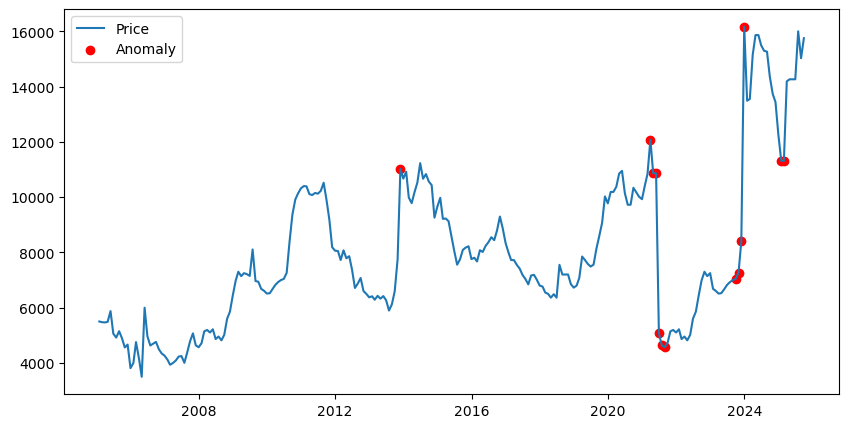

In [688]:
plt.figure(figsize=(10,5))
plt.plot(df.index, df['avg_monthly_price'], label='Price')
plt.scatter(df[df['anomaly']].index,
            df[df['anomaly']]['avg_monthly_price'],
            color='red', label='Anomaly')
plt.legend()
plt.show()


In [690]:
df.loc[df['anomaly'], 'avg_monthly_price'] = df['avg_monthly_price'].rolling(3, center=True).median()


In [692]:
df.drop(columns=['z_score', 'anomaly'], inplace=True)


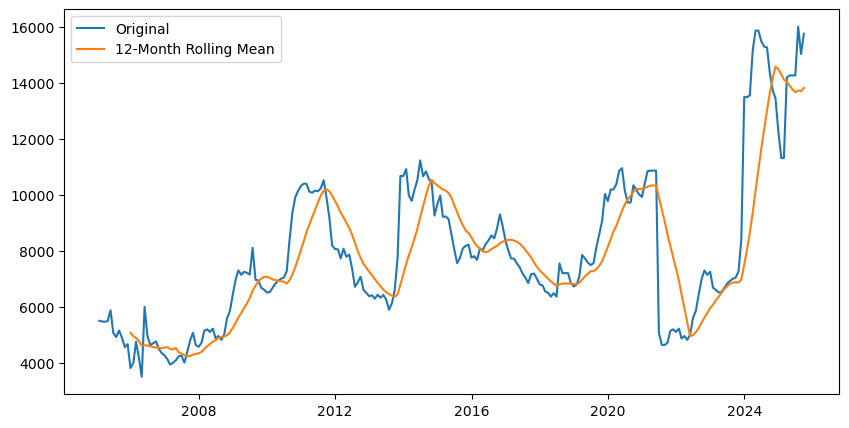

In [694]:
df['rolling_mean_12'] = df['avg_monthly_price'].rolling(12).mean()

plt.figure(figsize=(10,5))
plt.plot(df['avg_monthly_price'], label='Original')
plt.plot(df['rolling_mean_12'], label='12-Month Rolling Mean')
plt.legend()
plt.show()


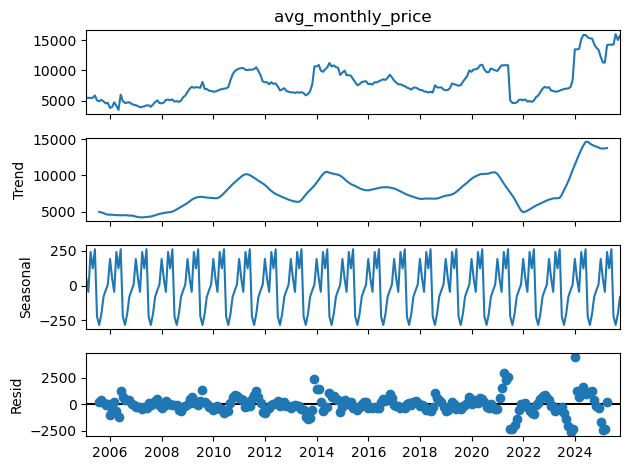

In [695]:
decomposition.plot()
plt.show()


In [697]:
df.head(20)

,avg_monthly_price,rolling_mean_12
date,,
2005-01-31,5500.0,NaN
2005-02-28,5476.0,NaN
2005-03-31,5466.0,NaN
2005-04-30,5487.0,NaN
2005-05-31,5876.0,NaN
2005-06-30,5058.0,NaN
2005-07-31,4919.0,NaN
2005-08-31,5149.0,NaN
2005-09-30,4899.0,NaN


In [698]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['avg_monthly_price'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -1.510430400225757
p-value: 0.5283454037884353


# Feature Engineering

In [701]:
df['lag_1'] = df['avg_monthly_price'].shift(1)
df['lag_2'] = df['avg_monthly_price'].shift(2)
df['lag_12'] = df['avg_monthly_price'].shift(12)


In [705]:
df['roll_mean_3'] = df['avg_monthly_price'].rolling(3).mean()
df['roll_std_3'] = df['avg_monthly_price'].rolling(3).std()


In [707]:
df['month'] = df.index.month
df['year'] = df.index.year
df.dropna(inplace=True)
df.drop(columns=['rolling_mean_12'],inplace=True)
df

,avg_monthly_price,lag_1,lag_2,lag_12,roll_mean_3,roll_std_3,month,year
date,,,,,,,,
2006-01-31,4000.0,3813.0,4665.0,5500.0,4159.333333,447.790502,1,2006
2006-02-28,4755.0,4000.0,3813.0,5476.0,4189.333333,498.724707,2,2006
2006-03-31,4176.0,4755.0,4000.0,5466.0,4310.333333,395.019409,3,2006
2006-04-30,3500.0,4176.0,4755.0,5487.0,4143.666667,628.124457,4,2006
2006-05-31,6000.0,3500.0,4176.0,5876.0,4558.666667,1293.184184,5,2006
...,...,...,...,...,...,...,...,...
2025-05-31,14263.0,14263.0,14188.0,15863.0,14238.000000,43.301270,5,2025
2025-06-30,14263.0,14263.0,14263.0,15488.0,14263.000000,0.000000,6,2025
2025-07-31,16000.0,14263.0,14263.0,15294.0,14842.000000,1002.857418,7,2025


In [709]:
X = df.drop(columns=['avg_monthly_price'])
y = df['avg_monthly_price']


In [711]:
train_size = int(len(df) * 0.8)

X_train = X.iloc[:train_size]
X_test  = X.iloc[train_size:]

y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]


In [713]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 189 entries, 2006-01-31 to 2021-09-30
Freq: ME
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lag_1        189 non-null    float64
 1   lag_2        189 non-null    float64
 2   lag_12       189 non-null    float64
 3   roll_mean_3  189 non-null    float64
 4   roll_std_3   189 non-null    float64
 5   month        189 non-null    int32  
 6   year         189 non-null    int32  
dtypes: float64(5), int32(2)
memory usage: 10.3 KB


In [715]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2021-10-31 to 2025-09-30
Freq: ME
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lag_1        48 non-null     float64
 1   lag_2        48 non-null     float64
 2   lag_12       48 non-null     float64
 3   roll_mean_3  48 non-null     float64
 4   roll_std_3   48 non-null     float64
 5   month        48 non-null     int32  
 6   year         48 non-null     int32  
dtypes: float64(5), int32(2)
memory usage: 2.6 KB


In [717]:
y_test.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 48 entries, 2021-10-31 to 2025-09-30
Freq: ME
Series name: avg_monthly_price
Non-Null Count  Dtype  
--------------  -----  
48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


In [719]:
future_dates = pd.date_range(
    start=df.index[-1] + pd.offsets.MonthEnd(1),
    periods=50,
    freq='ME'
)


In [721]:
future_df = df.copy()

future_predictions = []

for date in future_dates:
    last_row = future_df.iloc[-1]

    new_row = {
        'lag_1': last_row['avg_monthly_price'],
        'lag_2': future_df.iloc[-2]['avg_monthly_price'],
        'lag_12': future_df.iloc[-12]['avg_monthly_price'],
        'roll_mean_3': future_df['avg_monthly_price'].tail(3).mean(),
        'roll_std_3': future_df['avg_monthly_price'].tail(3).std(),
        'month': date.month,
        'year': date.year
    }

    new_row_df = pd.DataFrame([new_row])
    pred_price = rf.predict(new_row_df)[0]

    future_predictions.append(pred_price)

    future_df.loc[date] = [pred_price] + list(new_row.values())


In [764]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX( 
    y_train, 
    order=(1,1,1), 
    seasonal_order=(1,1,1,12))
sarima_fit = model.fit()

sarima_pred = sarima_fit.forecast(steps=len(y_test))
sarima_pred.index = y_test.index


In [766]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae  = mean_absolute_error(y_test, sarima_pred)
rmse = np.sqrt(mean_squared_error(y_test, sarima_pred))

print("MAE :", mae)
print("RMSE:", rmse)


MAE : 6417.907356526779
RMSE: 8080.455266615746


In [768]:
result_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': sarima_pred.round().astype(int)
})

print(result_df)


             Actual  Predicted
date                          
2021-10-31   5144.0       4809
2021-11-30   5194.0       4865
2021-12-31   5102.0       4707
2022-01-31   5218.0       4903
2022-02-28   4865.0       4887
2022-03-31   4956.0       5049
2022-04-30   4819.0       5078
2022-05-31   5015.0       5112
2022-06-30   5600.0       3832
2022-07-31   5856.0       3751
2022-08-31   6450.0       3811
2022-09-30   6982.0       4084
2022-10-31   7300.0       4198
2022-11-30   7141.0       4256
2022-12-31   7250.0       4104
2023-01-31   6681.0       4309
2023-02-28   6612.0       4307
2023-03-31   6510.0       4465
2023-04-30   6525.0       4492
2023-05-31   6669.0       4526
2023-06-30   6823.0       3109
2023-07-31   6925.0       3017
2023-08-31   7000.0       3075
2023-09-30   7040.0       3342
2023-10-31   7262.0       3456
2023-11-30   8400.0       3514
2023-12-31  13488.0       3361
2024-01-31  13488.0       3566
2024-02-29  13550.0       3564
2024-03-31  15150.0       3722
2024-04-

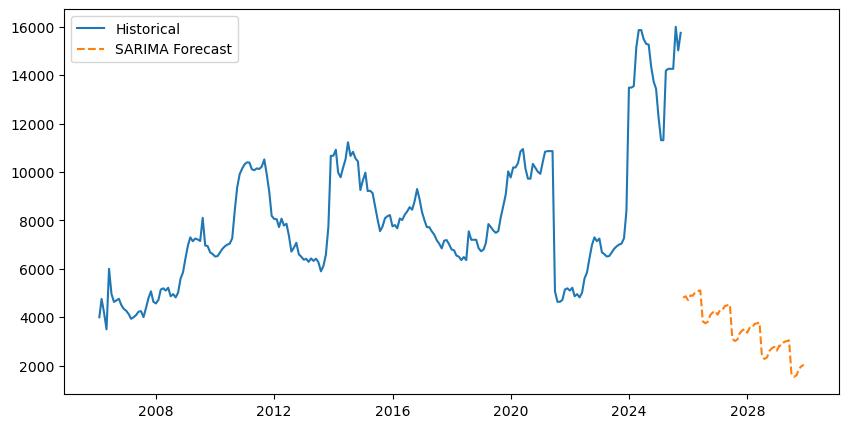

In [772]:
sarima_forecast_int = sarima_forecast.round().astype(int)
plt.figure(figsize=(10,5))
plt.plot(df.index, df['avg_monthly_price'], label='Historical')
plt.plot(future_dates, sarima_forecast_int, label='SARIMA Forecast', linestyle='--')
plt.legend()
plt.show()


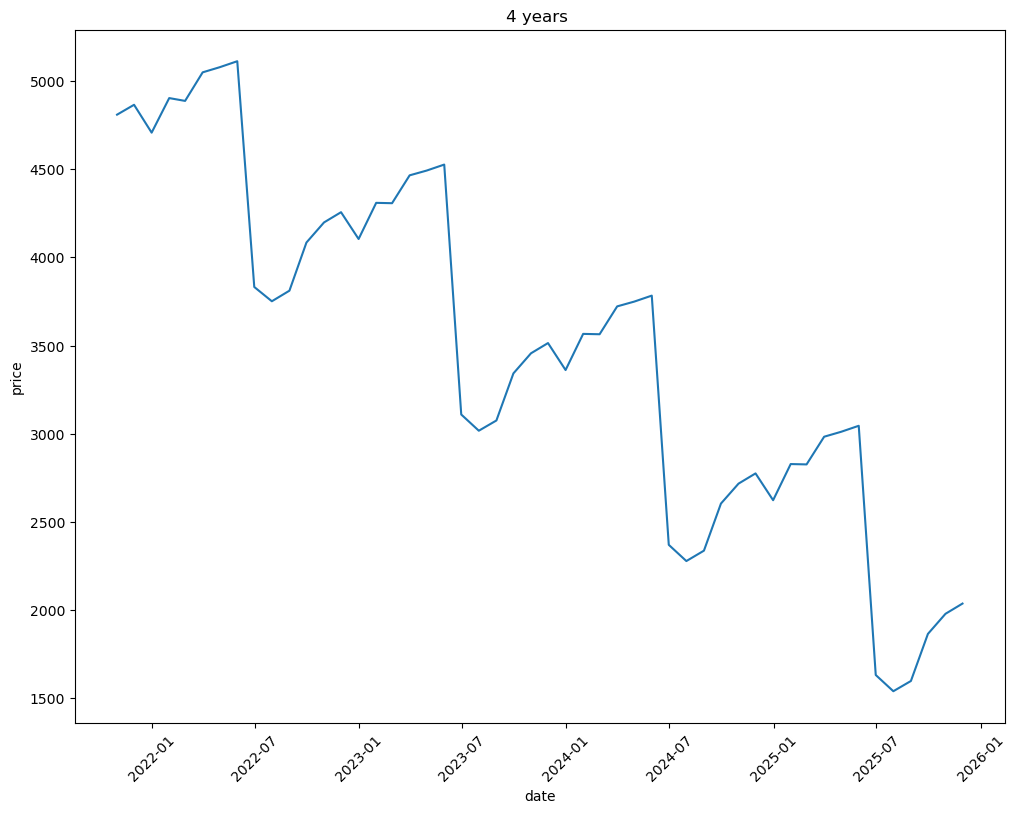

In [774]:
plt.figure(figsize=(12,9))
plt.title("4 years ")
plt.plot(sarima_forecast_int)
plt.xlabel("date")
plt.ylabel("price")
plt.xticks(rotation=45)
plt.show()


In [776]:
print("Train mean:", y_train.mean())
print("Predicted mean:", sarima_pred.mean())


Train mean: 7565.169312169312
Predicted mean: 3538.2477195788338


In [782]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    df['avg_monthly_price'],
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
)

sarima_fit = model.fit()


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


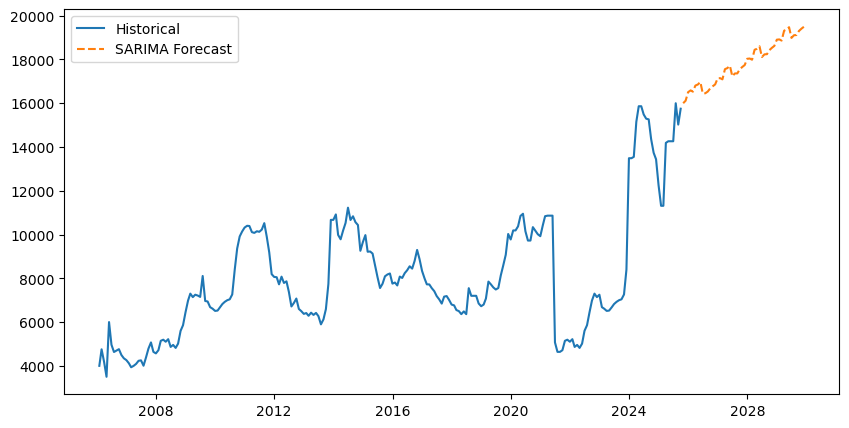

In [788]:
sarima_forecast = sarima_fit.forecast(steps=50)

plt.figure(figsize=(10,5))
plt.plot(df.index, df['avg_monthly_price'], label='Historical')
plt.plot(future_dates, sarima_forecast, label='SARIMA Forecast', linestyle='--')
plt.legend()
plt.show()


In [792]:
import pickle
with open("sarima_model.pkl", "wb") as f:
    pickle.dump(sarima_fit, f)

print("SARIMA model saved as sarima_model.pkl")


SARIMA model saved as sarima_model.pkl
